In [1]:
from Calculator import Calculator as Calc
from PlotTools import createPlot
from utils import (
    pd, np, getSchema, getDateBeforeTrade, 
    saveRecommand, timedelta, GetException,
    sendResultTable, VolumeFilter, PriceFilter,
    changedType, datetime, timedelta
)
from pprint import pprint

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [5]:
def FindCrossDayTradeTicker(td = datetime.today(), min_price=0, max_price=50, num_shares=10000, shares_ratio=0):
    try:
        td, last = getDateBeforeTrade(td.replace(hour=18))
        # setup data
        schema = getSchema('TWSE')
        table = schema['StockList']
        last_date = sorted(table.distinct("UpdateDate"))[-1]
        info_data = dict((x['Ticker'], x['Industry']+f"({x['Market'][-1]})") for x in table.find({"UpdateDate":{"$eq":last_date}, "Industry" :{"$ne":""}}) if "金融" not in x['Industry'])
        
        schema = getSchema('TWSE')
        table = schema['historicalPrice']
        data = list(table.find({'Date':{'$gte':last.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker" :{"$in":list(info_data.keys())}}))
        
        df = pd.DataFrame(data).set_index('Date')
        if len(df.index.unique()) < 2:
            data = list(table.find({'Date':{'$gte':(last+timedelta(-30)).strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}}))
            df = pd.DataFrame(data).set_index('Date')
            df = df.loc[sorted(df.index.unique())[-2:], :]
        del df['_id']
        for col in 'Open,High,Low,Close,Volume'.split(','):
            df[col] = df[col].apply(changedType)
        df["Adj V"] = df["Volume"].apply(lambda x: int(x/1000))
        
        # print(df.loc[sorted(df.index.unique())[-1],:].Volume >= num_shares)

        
        last_df = df.loc[sorted(df.index.unique())[-1],:].reset_index().set_index("Ticker")
        # 強勢股
        last_df = last_df[last_df.Volume >= 1000]
        last_df['Ret'] = 0
        last_df["HighRet"] = 0
        for ticker in last_df.index.unique():
            last_df.loc[ticker, "Ret"] = df[df.Ticker == ticker].Close.pct_change()[-1]
            try:
                last_df.loc[ticker, "HighRet"] = (df[df.Ticker == ticker].High.iloc[-1] / df[df.Ticker == ticker].Close.iloc[-2]) - 1
            except:
                pass
        last_df = last_df[last_df["Adj V"] >= num_shares]
        ticker_volume_filted = last_df.index
        
        final_select = []
        pre_3y = td + timedelta(-365*3)
        momentums = []
        for ticker in ticker_volume_filted:#df.Ticker.unique():
            try:
                temp_df = pd.DataFrame(list(table.find({'Ticker':{'$eq':ticker},'Date':{'$gte':pre_3y.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}}))).set_index('Date')
                
                if temp_df is None:
                    print(ticker, 'is None', temp_df)
                    continue
                if temp_df.empty:
                    print(ticker, 'is empty', temp_df)
                    continue
                for col in 'Open,High,Low,Close,Volume'.split(','):
                    temp_df[col] = temp_df[col].apply(changedType)
                
                # temp_df = Calc.MACD(temp_df)
                # temp_df = Calc.DI(temp_df)
                temp_df = Calc.MA(temp_df, [5, 10, 20, 60, 150], 'Close')
                # temp_df = Calc.EMA(temp_df, [67, 23])
                # temp_df = Calc.calculateTOWER(temp_df)
                # temp_df = Calc.BBAND(temp_df, 20, 2)
                # temp_df['slope'] = temp_df['MA20'].pct_change()
                temp_df['Ret'] = temp_df.Close.pct_change()
                temp_df['slope_5'] = temp_df['MA5'].pct_change()
                temp_df['slope_10'] = temp_df['MA10'].pct_change()
                temp_df['Adj V'] = temp_df.Volume.apply(lambda x: int(x/1000))
                temp_df['VMA5'] = temp_df['Adj V'].rolling(5).mean()
                temp_df['VMA20'] = temp_df['Adj V'].rolling(20).mean()
                # # temp_df['upslope'] = temp_df['upband'].pct_change()
                # # temp_df['bandwidth'] = temp_df['upband'] / temp_df['dnband'] - 1
                v_ratio = (temp_df['Adj V'].iloc[-1] / temp_df['Adj V'].iloc[-2])
                v_slope = temp_df.VMA20.pct_change().iloc[-1]
                
                condi_1 = min(temp_df.VMA5.iloc[-1], temp_df.VMA20.iloc[-1]) >= 5000
                condi_2 = temp_df.slope_10.iloc[-1] > 0 and temp_df.MA5.iloc[-1] > temp_df.MA10.iloc[-1]
                condi_3 = temp_df.MA10.iloc[-1] > temp_df.MA20.iloc[-1]
                condi_4 = 1.5 <= v_ratio and v_ratio <= 5
                condi_5 = temp_df.slope_5.iloc[-1] > 0
                # condi_5 = temp_df.slope.iloc[-1] > 0
                condi_6 = v_slope > 0
                condi_7 = temp_df.High.iloc[-1] >= temp_df.High.iloc[-5:].max()
                if all([condi_1, condi_2, condi_3, condi_4, condi_5, condi_6, condi_7]): #, condi_8
                    final_select.append(ticker)
            except:
                pass
        return final_select
    except:
        # print(f'ticker : {ticker}\t Error : ',GetException())
        print(f'Error : ',GetException())
        return []

def Backtest(td = datetime.today(), tickers=[]):
    try:
        # setup date
        now = datetime.now()
        td, last = getDateBeforeTrade(td.replace(hour=18))
        # setup data
        schema = getSchema('TWSE')
        table = schema['StockList']
        last_date = sorted(table.distinct("UpdateDate"))[-1]
        info_data = dict((x['Ticker'], x['Industry']+f"({x['Market'][-1]})") for x in table.find({"UpdateDate":{"$eq":last_date}, "Industry" :{"$ne":""}}) if x['Ticker'] in tickers and "金融" not in x['Industry'])

        schema = getSchema('TWSE')
        table = schema['historicalPrice']
        data = list(table.find({'Date':{'$gte':last.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker":{"$in":list(info_data.keys())}}))
        
        df = pd.DataFrame(data).set_index('Date')
        if len(df.index.unique()) < 2:
            data = list(table.find({'Date':{'$gte':(last+timedelta(-30)).strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}, "Ticker":{"$in":list(info_data.keys())}}))
            df = pd.DataFrame(data).set_index('Date')
            df = df.loc[sorted(df.index.unique())[-2:], :]
        del df['_id']
        for col in 'Open,High,Low,Close,Volume'.split(','):
            df[col] = df[col].apply(changedType)
        try:
            last_df = df.loc[sorted(df.index.unique())[-1],:].reset_index().set_index("Ticker")
        except:
            last_df = df.loc[[sorted(df.index.unique())[-1]],:].reset_index().set_index("Ticker")
        last_df['Ret'] = 0
        last_df["HighRet"] = 0
        last_df["LowRet"] = 0
        last_df["PnL"] = 0
        for ticker in last_df.index.unique():
            last_df.loc[ticker, "Ret"] = df[df.Ticker == ticker].Close.pct_change()[-1]
            try:
                last_df.loc[ticker, "HighRet"] = (df[df.Ticker == ticker].High.iloc[-1] / df[df.Ticker == ticker].Close.iloc[-2]) - 1
                last_df.loc[ticker, "LowRet"] = (df[df.Ticker == ticker].Low.iloc[-1] / df[df.Ticker == ticker].Close.iloc[-2]) - 1
                if (last_df.loc[ticker, "HighRet"] >= 0.02):
                    last_df.loc[ticker, "PnL"] = round((Calc.CalculateUpDnLimit(df[df.Ticker == ticker].Close.iloc[-2], 0.02)[0] - df[df.Ticker == ticker].Close.iloc[-2]) * 1000)
                elif last_df.loc[ticker, "LowRet"] <= -0.05:
                    last_df.loc[ticker, "PnL"] = round((Calc.CalculateUpDnLimit(df[df.Ticker == ticker].Close.iloc[-2], 0.02, 0.05)[1] - df[df.Ticker == ticker].Close.iloc[-2]) * 1000)
                else:
                    last_df.loc[ticker, "PnL"] = round((df[df.Ticker == ticker].Close.iloc[-1] - df[df.Ticker == ticker].Close.iloc[-2]) * 1000)
            except:
                pass
        # last_df = last_df.sort_values("Ret", ascending=False)[:100]
        pprint(last_df[['Ret', 'HighRet', 'LowRet', 'PnL']])
        # last_df = last_df[last_df["HighRet"] >= 0.02]
        # last_df = last_df[last_df["Adj V"] >= num_shares]
        ticker_volume_filted = last_df[last_df["HighRet"] >= 0.02].index
        total_pnl = last_df["PnL"].sum()
#         for row in last_df.itertuples():
#             print(row.Index, row.PnL)
        print("all : ", len(tickers), tickers)
        print("trade : ", len(info_data.keys()), list(info_data.keys()))
        print("Max Ret >= 2% : ", len(ticker_volume_filted), ticker_volume_filted.tolist())
        # print(f"profit Probability for all : {round(len(ticker_volume_filted) / len(tickers)*100, 2)} %")
        print(f"profit Probability for trade : {round(len(ticker_volume_filted) / len(info_data.keys())*100, 2)} %")
        print(f'Total PnL without cost: {total_pnl}')
        return list(last_df.T.to_dict().values())
    except:
        # print(f'ticker : {ticker}\t Error : ',GetException())
        print(f'Error : ',GetException())
        pass

In [3]:
def MainBacktest(date = datetime(2022,1,14)):
    try:
        print("\n\n=======================回測開始=======================")
        tdStr = date.strftime('%Y-%m-%d')
        if date.isocalendar()[-1] > 5:
            print(f"{tdStr} is Holiday.")
            return
        i = -1
        while i:
            last_date = date + timedelta(i)
            if last_date.isocalendar()[-1] <= 5:
                break
            i -= 1

        print(f"Backtest {tdStr}, ticker prepare from {last_date.strftime('%Y-%m-%d')}.\n")
        tickers = FindCrossDayTradeTicker(last_date, min_price=0, max_price=9999, num_shares=1000, shares_ratio=1.5)
        if tickers:
            print(tickers, '\n')
            return Backtest(date, tickers)
        else:
            print(f"No Tickers for {tdStr} to Trade.\n")
            return []
    except:
        return []

In [ ]:
result = {}

In [13]:
start_date = datetime(2022,1,3)
end_date = datetime(2022,1,20)

for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
Backtest 2022-01-03, ticker prepare from 2021-12-31.



c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['1314', '1560', '2323', '2405', '2457', '3047', '3481', '5371', '6116', '6120', '6164', '6196'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1314   -0.015209  0.011407 -0.019011  -200
1560   -0.049587  0.037190 -0.053719  2000
2323    0.096070  0.096070  0.000000   200
2405   -0.071429 -0.024631 -0.096059 -1000
2457    0.007952  0.019881 -0.024851   400
3047    0.031579  0.045614  0.003509   250
3481   -0.020408  0.010204 -0.020408  -400
5371   -0.048701  0.006494 -0.048701 -4500
6116   -0.019337  0.005525 -0.022099  -350
6120    0.006250  0.031250 -0.012500   300
6164   -0.034091 -0.008523 -0.034091  -600
6196   -0.032967  0.043956 -0.035714  3500
all :  12 ['1314', '1560', '2323', '2405', '2457', '3047', '3481', '5371', '6116', '6120', '6164', '6196']
trade :  12 ['1314', '1560', '2323', '2405', '2457', '3047', '3481', '6116', '6120', '6164', '6196', '5371']
Max Ret >= 2% :  5 ['1560', '2323', '3047', '6120', '6196']
profit Probability for 

['1316'] 

             Ret   HighRet    LowRet  PnL
Ticker                                   
1316    0.048523  0.099156 -0.018987  450
all :  1 ['1316']
trade :  1 ['1316']
Max Ret >= 2% :  1 ['1316']
profit Probability for trade : 100.0 %
Total PnL without cost: 450
=======================回測開始=======================
Backtest 2022-01-19, ticker prepare from 2022-01-18.

['1316', '2324', '2393', '3036', '3455', '3702', '6147'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1316    0.072435  0.096579 -0.014085   450
2324    0.000000  0.003929 -0.007859     0
2393    0.000000  0.007018 -0.026316     0
3036   -0.056541 -0.015521 -0.056541 -4500
3455    0.034483  0.034483 -0.021675  2000
3702   -0.001835  0.001835 -0.007339  -100
6147   -0.012857  0.005714 -0.018571  -900
all :  7 ['1316', '2324', '2393', '3036', '3455', '3702', '6147']
trade :  7 ['1316', '2324', '2393', '3036', '3702', '3455', '6147']
Max Ret >= 2% :  2 ['1316', '3455']
profit Pr

In [7]:
start_date = datetime(2021,12,1)
end_date = datetime(2021,12,30)
# result = {}
for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
Backtest 2021-12-01, ticker prepare from 2021-11-30.

['1907', '2331', '2344', '2353', '2355', '2375', '3019', '4927', '6182'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1907    0.002894  0.010130 -0.018813   100
2331   -0.004024  0.018109 -0.020121  -100
2344    0.010920  0.018721 -0.017161   350
2353    0.014440  0.021661 -0.007220   550
2355    0.045082  0.057377  0.013661   700
2375    0.000000  0.034188 -0.021368  2000
3019    0.024218  0.024218 -0.019173  1900
4927   -0.096491 -0.008772 -0.096491 -5500
6182    0.059902  0.079462  0.009780  1600
all :  9 ['1907', '2331', '2344', '2353', '2355', '2375', '3019', '4927', '6182']
trade :  9 ['1907', '2331', '2344', '2353', '2355', '2375', '3019', '4927', '6182']
Max Ret >= 2% :  5 ['2353', '2355', '2375', '3019', '6182']
profit Probability for trade : 55.56 %
Total PnL without cost: 1600
=======================回測開始=======================
Ba

['1708', '2347', '2406', '3051', '3059', '6118', '6120', '6226', '6244'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1708   -0.021858  0.031421 -0.021858   700
2347    0.000000  0.026521  0.000000  1200
2406    0.098684  0.098684 -0.003289   600
3051    0.097859  0.097859  0.070336   300
3059    0.038418  0.082486 -0.011299   850
6118    0.098927  0.098927  0.051251   800
6120    0.098940  0.098940  0.035336   250
6226    0.018750  0.040625 -0.006250   300
6244    0.002660  0.046543 -0.003989   750
all :  9 ['1708', '2347', '2406', '3051', '3059', '6118', '6120', '6226', '6244']
trade :  9 ['1708', '2347', '2406', '3051', '3059', '6120', '6226', '6118', '6244']
Max Ret >= 2% :  9 ['1708', '2347', '2406', '3051', '3059', '6118', '6120', '6226', '6244']
profit Probability for trade : 100.0 %
Total PnL without cost: 5750
=======================回測開始=======================
Backtest 2021-12-14, ticker prepare from 2021-12-13.

['1611', '2002', '239

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['2313', '2374', '2405', '2457', '2476', '3033', '3217', '3322', '6235'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2313    0.011481  0.016073  0.002296   500
2374    0.099206  0.099206  0.017857   500
2405    0.005222  0.015666 -0.007833   100
2457    0.053854  0.098205  0.014784   900
2476    0.094101  0.095506  0.025281  1400
3033   -0.010920  0.014041 -0.015601  -350
3217    0.000000  0.017241 -0.024138     0
3322    0.099237  0.099237  0.053435   500
6235   -0.044321  0.044321 -0.044321   700
all :  9 ['2313', '2374', '2405', '2457', '2476', '3033', '3217', '3322', '6235']
trade :  9 ['2313', '2374', '2405', '2457', '2476', '3033', '6235', '3217', '3322']
Max Ret >= 2% :  5 ['2374', '2457', '2476', '3322', '6235']
profit Probability for trade : 55.56 %
Total PnL without cost: 4250
=======================回測開始=======================
Backtest 2021-12-24, ticker prepare from 2021-12-23.

['2312', '2340', '2367', '2374', '2399', '2412', '245

In [14]:
start_date = datetime(2021,11,1)
end_date = datetime(2021,11,30)
# result = {}
for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
Backtest 2021-11-01, ticker prepare from 2021-10-29.

['2329', '2351', '2388', '2481', '3264', '3305', '3508', '3707', '4128', '4739', '5285', '5425', '6182', '6237', '6485', '6509', '8215'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2329    0.016129  0.032258  0.006048   450
2351    0.099398  0.099398  0.060241  3000
2388    0.099839  0.099839  0.024155  1200
2481    0.097778  0.097778  0.031111  2000
3264    0.035354  0.037037 -0.001684  1100
3305    0.060820  0.087694  0.015559  1400
3508    0.099678  0.099678  0.054662   600
3707    0.085246  0.098361  0.000000  3000
4128   -0.028436  0.014218 -0.047393 -1800
4739   -0.002915  0.029155 -0.020408  3000
5285    0.098361  0.098361  0.012295  2000
5425    0.099754  0.099754  0.034483  1600
6182    0.059190  0.065421  0.020249  1200
6237    0.098039  0.098039  0.039216  2000
6485    0.011407  0.034221 -0.003802  2500
6509   -0.001248  0.03495

['1440', '1717', '2330', '2337', '2363', '2368', '3006', '3033', '3508', '4927', '4961', '6244', '6485', '8150', '8215', '8358'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1440    0.031056  0.099379 -0.006211   450
1717   -0.017812  0.006361 -0.021628  -700
2330    0.001637  0.001637 -0.004910  1000
2337    0.024331  0.024331 -0.010949   800
2363   -0.015842  0.000000 -0.023762  -400
2368   -0.029412 -0.005602 -0.033613 -2100
3006    0.020202  0.020202 -0.023569  2500
3033    0.099825  0.099825  0.015762   550
3508    0.100000  0.100000  0.027160   800
4927   -0.013889  0.014957 -0.037393 -1300
4961   -0.009029  0.006772 -0.027088 -2000
6244   -0.018841  0.000000 -0.018841  -650
6485    0.074733  0.099644  0.003559  2500
8150   -0.016112  0.001074 -0.020408  -750
8215   -0.030504  0.000000 -0.034483 -1150
8358   -0.011688  0.003896 -0.020779  -900
all :  16 ['1440', '1717', '2330', '2337', '2363', '2368', '3006', '3033', '3508', '4927', '496

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['1312', '1402', '2038', '2344', '2368', '2498', '3059', '3588', '6104', '8040'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1312   -0.025381 -0.001692 -0.035533  -750
1402   -0.004975  0.008292 -0.004975  -150
2038   -0.059445 -0.003963 -0.059445 -1850
2344    0.027257  0.039182  0.018739   550
2368    0.057613  0.064472  0.012346  1400
2498    0.000000  0.070407 -0.041804  1800
3059   -0.012285  0.023342 -0.015971   800
3588    0.012422  0.077640 -0.012422  3000
6104    0.099698  0.099698  0.030211  3000
8040    0.099310  0.099310  0.020690  1400
all :  10 ['1312', '1402', '2038', '2344', '2368', '2498', '3059', '3588', '6104', '8040']
trade :  10 ['1312', '1402', '2038', '2344', '2368', '2498', '3059', '3588', '6104', '8040']
Max Ret >= 2% :  7 ['2344', '2368', '2498', '3059', '3588', '6104', '8040']
profit Probability for trade : 70.0 %
Total PnL without cost: 9200
=======================回測開始=======================
Backtest 2021-11-16, ti

['2340', '2344', '2369', '2408', '3006', '3016', '3019', '3049', '3260', '3704', '3714', '4916', '5483', '6104', '6147', '6182', '8183'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2340   -0.036545  0.099668 -0.043189  1200
2344   -0.014173  0.014173 -0.023622  -450
2369   -0.042125 -0.009158 -0.042125 -1150
2408    0.003979  0.015915 -0.022546   300
3006   -0.024242 -0.003030 -0.039394 -4000
3016   -0.090604 -0.003356 -0.097315 -7000
3019   -0.049231 -0.005128 -0.054359 -4800
3049   -0.029703  0.056106 -0.036304   300
3260   -0.023404  0.021277 -0.036170  1800
3704   -0.046377 -0.002899 -0.055072 -1700
3714   -0.002488  0.038557 -0.009950  1600
4916   -0.099087  0.031291 -0.099087   750
5483    0.007299  0.029197 -0.009732  4000
6104   -0.023256  0.031008 -0.062016  3500
6147   -0.010249  0.001464 -0.013177  -700
6182   -0.023876  0.001404 -0.030899 -1700
8183    0.044335  0.077176  0.000000  1200
all :  17 ['2340', '2344', '2369', '2408', '

In [20]:
start_date = datetime(2021,10,1)
end_date = datetime(2021,10,31)
# result = {}
for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
Backtest 2021-10-01, ticker prepare from 2021-09-30.

['1440', '1609', '2354', '2436', '2606', '2610', '2618', '3062', '6217'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1440   -0.087786  0.009542 -0.095420 -1300
1609   -0.022430  0.035514 -0.028037   500
2354   -0.038407 -0.002845 -0.051209 -3500
2436   -0.025611  0.016298 -0.067520 -4200
2606   -0.083090  0.010204 -0.090379 -3400
2610   -0.029070  0.017442 -0.037791  -500
2618   -0.021164  0.015873 -0.029101  -400
3062   -0.021378  0.026128 -0.040380   400
6217   -0.095192 -0.003846 -0.100000 -2600
all :  9 ['1440', '1609', '2354', '2436', '2606', '2610', '2618', '3062', '6217']
trade :  9 ['1440', '1609', '2354', '2436', '2606', '2610', '2618', '3062', '6217']
Max Ret >= 2% :  2 ['1609', '3062']
profit Probability for trade : 22.22 %
Total PnL without cost: -15000
=======================回測開始=======================
2021-10-02 is Holiday.
=

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['1440'] 

             Ret   HighRet    LowRet  PnL
Ticker                                   
1440   -0.073222  0.029289 -0.075314  450
all :  1 ['1440']
trade :  1 ['1440']
Max Ret >= 2% :  1 ['1440']
profit Probability for trade : 100.0 %
Total PnL without cost: 450
=======================回測開始=======================
Backtest 2021-10-05, ticker prepare from 2021-10-04.



c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['1722', '2618', '5905'] 

             Ret   HighRet    LowRet  PnL
Ticker                                   
1722    0.007194  0.007194 -0.028777  500
2618    0.010811  0.016216 -0.024324  200
5905   -0.008876  0.029586 -0.017751  300
all :  3 ['1722', '2618', '5905']
trade :  3 ['1722', '2618', '5905']
Max Ret >= 2% :  1 ['5905']
profit Probability for trade : 33.33 %
Total PnL without cost: 1000
=======================回測開始=======================
Backtest 2021-10-06, ticker prepare from 2021-10-05.

No Tickers for 2021-10-06 to Trade.

=======================回測開始=======================
Backtest 2021-10-07, ticker prepare from 2021-10-06.

['1710', '1785', '9958'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1710    0.019272  0.027837 -0.014989   450
1785    0.009579  0.011494 -0.015326   500
9958    0.012295  0.016393 -0.040984  1500
all :  3 ['1710', '1785', '9958']
trade :  3 ['1710', '9958', '1785']
Max Ret >= 2% :  1 ['1710']
profit Pro

['2498', '2913', '3504', '4927', '8069'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2498    0.009524  0.038095 -0.026667  1000
2913    0.000000  0.007042 -0.014085     0
3504    0.022388  0.063433  0.007463  2500
4927   -0.040842 -0.001238 -0.043317 -3300
8069    0.005774  0.010393 -0.018476   500
all :  5 ['2498', '2913', '3504', '4927', '8069']
trade :  5 ['2498', '2913', '3504', '4927', '8069']
Max Ret >= 2% :  2 ['2498', '3504']
profit Probability for trade : 40.0 %
Total PnL without cost: 700
=======================回測開始=======================
Backtest 2021-10-26, ticker prepare from 2021-10-25.

['2340', '3305', '4721', '4739', '6217', '6509'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2340    0.057796  0.099462  0.001344   700
3305   -0.019449  0.009724 -0.024311 -1200
4721    0.014085  0.091549  0.007042  2500
4739    0.060498  0.099644  0.032028  2500
6217   -0.006849  0.049658 -0.011986  

In [21]:
start_date = datetime(2021,9,1)
end_date = datetime(2021,9,30)
# result = {}
for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
Backtest 2021-09-01, ticker prepare from 2021-08-31.

['1785', '2324', '2331', '2618', '2641', '9945'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1785    0.002008  0.004016 -0.012048   100
2324   -0.002183  0.000000 -0.010917   -50
2331    0.004032  0.024194 -0.018145   450
2618   -0.018229  0.005208 -0.028646  -350
2641   -0.045994 -0.011869 -0.065282 -1650
9945    0.028860  0.041847 -0.005772  1300
all :  6 ['1785', '2324', '2331', '2618', '2641', '9945']
trade :  6 ['2324', '2331', '2618', '9945', '1785', '2641']
Max Ret >= 2% :  2 ['2331', '9945']
profit Probability for trade : 33.33 %
Total PnL without cost: -200
=======================回測開始=======================
Backtest 2021-09-02, ticker prepare from 2021-09-01.

['2340', '2371', '2476', '3141', '3504', '3707', '4919', '8064', '8150'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2340    0.00

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


No Tickers for 2021-09-09 to Trade.

=======================回測開始=======================
Backtest 2021-09-10, ticker prepare from 2021-09-09.

['2608', '3689', '4927'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2608   -0.072566  0.017699 -0.079646 -2800
3689    0.015504  0.052326 -0.035853  1000
4927    0.022378  0.037762 -0.020979  1400
all :  3 ['2608', '3689', '4927']
trade :  3 ['2608', '4927', '3689']
Max Ret >= 2% :  2 ['3689', '4927']
profit Probability for trade : 66.67 %
Total PnL without cost: -400
=======================回測開始=======================
2021-09-11 is Holiday.
=======================回測開始=======================
2021-09-12 is Holiday.
=======================回測開始=======================
Backtest 2021-09-13, ticker prepare from 2021-09-10.

['1584', '1727', '2002', '2069', '3033', '3689', '5347', '8415'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1584    0.086849  0.099256 -0.022333

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['2356', '2371', '6217'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2356    0.003937  0.035433  0.001969   500
2371    0.099526  0.099526  0.006319   600
6217    0.009921  0.067460 -0.010913  1000
all :  3 ['2356', '2371', '6217']
trade :  3 ['2356', '2371', '6217']
Max Ret >= 2% :  3 ['2356', '2371', '6217']
profit Probability for trade : 100.0 %
Total PnL without cost: 2100
=======================回測開始=======================
Backtest 2021-09-24, ticker prepare from 2021-09-23.

['1304', '2486', '6213', '6282'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1304    0.027704  0.044855  0.006596   750
2486    0.040067  0.085142  0.015025  1100
6213   -0.002994  0.017964 -0.029940  -500
6282   -0.015332  0.008518 -0.022147  -450
all :  4 ['1304', '2486', '6213', '6282']
trade :  4 ['1304', '2486', '6213', '6282']
Max Ret >= 2% :  2 ['1304', '2486']
profit Probability for trade : 50.0 %
Total PnL without 

In [22]:
start_date = datetime(2021,8,1)
end_date = datetime(2021,8,31)
# result = {}
for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
2021-08-01 is Holiday.
=======================回測開始=======================
Backtest 2021-08-02, ticker prepare from 2021-07-30.

['2007', '2301', '2329', '2363', '3031', '3556', '6104', '6226', '6485'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2007    0.099526  0.099526  0.000000   600
2301   -0.003120  0.004680 -0.014041  -200
2329    0.018519  0.046296 -0.042593   500
2363   -0.003906  0.039062 -0.015625   500
3031   -0.006623  0.026490 -0.064570   600
3556    0.008811  0.057269 -0.044053  2000
6104    0.067669  0.082707  0.022556  2500
6226   -0.018182  0.036364 -0.064935   350
6485    0.098160  0.098160  0.018405  3000
all :  9 ['2007', '2301', '2329', '2363', '3031', '3556', '6104', '6226', '6485']
trade :  9 ['2007', '2301', '2329', '2363', '3031', '6226', '3556', '6104', '6485']
Max Ret >= 2% :  8 ['2007', '2329', '2363', '3031', '3556', '6104', '6226', '6485']
profit Probability for 

['2612'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2612    0.099112  0.099112  0.060651  1300
all :  1 ['2612']
trade :  1 ['2612']
Max Ret >= 2% :  1 ['2612']
profit Probability for trade : 100.0 %
Total PnL without cost: 1300
=======================回測開始=======================
Backtest 2021-08-20, ticker prepare from 2021-08-19.

['2013'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
2013    0.022857  0.032381 -0.038095  1000
all :  1 ['2013']
trade :  1 ['2013']
Max Ret >= 2% :  1 ['2013']
profit Probability for trade : 100.0 %
Total PnL without cost: 1000
=======================回測開始=======================
2021-08-21 is Holiday.
=======================回測開始=======================
2021-08-22 is Holiday.
=======================回測開始=======================
Backtest 2021-08-23, ticker prepare from 2021-08-20.

['2612'] 

             Ret   HighRet    LowRet   PnL
Ticker                                  

In [23]:
start_date = datetime(2021,7,1)
end_date = datetime(2021,7,31)
# result = {}
for date in pd.date_range(start_date, end_date):
    result[date.strftime("%Y-%m-%d")] = MainBacktest(date)

=======================回測開始=======================
Backtest 2021-07-01, ticker prepare from 2021-06-30.

['1308', '1909', '2034', '2069', '2356', '2449', '2455', '2481', '2486', '4105', '5009', '6443', '8086', '8415'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1308    0.100000  0.100000  0.068571   700
1909    0.001718  0.051546 -0.010309   550
2034   -0.039535  0.046512 -0.046512   850
2069    0.099462  0.099462  0.021505   700
2356   -0.001905  0.007619 -0.001905   -50
2449   -0.023385 -0.001114 -0.026726 -1050
2455   -0.029851  0.007463 -0.037313 -4000
2481   -0.075406  0.003480 -0.091647 -4300
2486   -0.013648  0.099256 -0.018610   800
4105   -0.027523  0.004587 -0.028670 -2400
5009   -0.025455  0.072727 -0.036364   550
6443   -0.031519  0.008596 -0.034384 -1100
8086   -0.035370  0.012862 -0.041801 -5500
8415   -0.045122  0.034146 -0.063415   800
all :  14 ['1308', '1909', '2034', '2069', '2356', '2449', '2455', '2481', '2486', '4105', '

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['1305', '1517', '1809', '2010', '2017', '2030', '2069', '2486', '2606', '2615', '2617', '2636', '2637', '2643', '6191', '6257', '6509'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1305   -0.061298  0.097356 -0.069712   800
1517   -0.010050  0.031826 -0.031826   550
1809   -0.022581  0.032258 -0.029032   300
2010   -0.033873  0.045655 -0.042710   650
2017   -0.037705  0.049180 -0.049180   600
2030    0.000000  0.016000 -0.050667 -1850
2069    0.099022  0.099022 -0.033007   800
2486    0.099371  0.099371 -0.005031   750
2606   -0.047351  0.029312 -0.066516  1700
2615   -0.028274  0.035714 -0.075893  6500
2617    0.026426  0.084840 -0.022253  1400
2636    0.071553  0.090750 -0.001745  5500
2637   -0.013514  0.045045 -0.063063  2000
2643   -0.067194  0.043478 -0.090909  2500
6191    0.004310  0.031609 -0.007184   650
6257    0.000000  0.007005 -0.014011     0
6509    0.099526  0.099526  0.042654   800
all :  17 ['1305', '1517', '1809', '2010', '

['1709', '1815', '2344', '2369', '2401', '2406', '3305', '3511', '3624', '4714', '5285', '5328', '6168', '8110'] 

             Ret   HighRet    LowRet   PnL
Ticker                                    
1709   -0.013857  0.006928 -0.016166  -300
1815    0.061662  0.088472  0.024129   350
2344   -0.008499  0.029745 -0.008499   700
2369    0.100000  0.100000  0.033333   450
2401    0.098996  0.098996  0.058824   650
2406    0.010571  0.033827  0.006342   450
3305    0.041026  0.076923  0.010256  1100
3511   -0.008961  0.075269 -0.023297  1100
3624    0.051923  0.094231  0.013462  1000
4714   -0.016779  0.013423 -0.020134  -250
5285    0.096916  0.096916  0.048458  2000
5328   -0.016760  0.033520 -0.022346   350
6168    0.099624  0.099624  0.077068   500
8110    0.100000  0.100000  0.046512   400
all :  14 ['1709', '1815', '2344', '2369', '2401', '2406', '3305', '3511', '3624', '4714', '5285', '5328', '6168', '8110']
trade :  14 ['1709', '2344', '2369', '2401', '2406', '3305', '5285', '6168

['1605', '1785', '1795', '1815', '2023', '2032', '2383', '2406', '2486', '3016', '4306', '4952', '5471', '6173', '6202', '6233', '6244', '6509', '8044', '8069', '8261', '9907', '9945'] 

             Ret   HighRet    LowRet    PnL
Ticker                                     
1605   -0.046823 -0.015050 -0.050167  -1450
1785    0.001908  0.017176 -0.015267    100
1795   -0.047458  0.037288 -0.050847   2500
1815   -0.062500 -0.018519 -0.074074  -1050
2023   -0.052826  0.012285 -0.088452  -2000
2032    0.024213  0.054479 -0.087167    800
2383   -0.047423  0.010309 -0.053608 -12000
2406    0.053333  0.062857 -0.038095    500
2486    0.037162  0.092905  0.000000   1100
3016    0.005495  0.082418  0.001099   1800
4306   -0.012563  0.012563 -0.015075   -250
4952    0.008111  0.086906 -0.057937   1700
5471   -0.035398 -0.008850 -0.053097  -5500
6173   -0.035526 -0.003947 -0.039474  -2700
6202   -0.045775  0.007042 -0.045775  -6500
6233    0.035824  0.074719 -0.022518    950
6244   -0.019971 -0.0

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in longlong_scalars


['2329', '2369', '2401', '2436', '2449', '3035', '3041', '3189', '4919', '4967', '5285', '5351', '6175', '6271', '8016', '8054', '8112', '9962'] 

             Ret   HighRet    LowRet    PnL
Ticker                                     
2329    0.038710  0.066667  0.002151    450
2369    0.010791  0.016187 -0.021583    300
2401    0.004474  0.060403 -0.026846    850
2436   -0.075824  0.004396 -0.076923  -4500
2449   -0.025026  0.014599 -0.027112  -1200
3035   -0.050633 -0.012658 -0.080169  -5500
3041    0.018663  0.018663 -0.027994    600
3189   -0.047733  0.026253 -0.069212   4000
4919   -0.078431  0.035948 -0.098039   3000
4967    0.010825  0.023004 -0.020298   1400
5285   -0.015209  0.091255 -0.064639   2500
5351   -0.007634  0.079607 -0.017448    900
6175   -0.040000  0.016364 -0.045455  -2200
6271   -0.025974  0.001855 -0.064935 -13000
8016   -0.004478  0.044776 -0.023881   6500
8054   -0.017570  0.079063 -0.032211   1300
8112   -0.003348  0.012277 -0.016741   -150
9962    0.098712 

In [24]:
plot_result = []
for k, v in result.items():
    if v:
        plot_result.append({'Date':k, "PnL":sum([x['PnL'] for x in v])})
    else:
        plot_result.append({'Date':k, "PnL":0})
    

In [25]:
plot_df = pd.DataFrame(plot_result).set_index("Date").sort_index()
plot_df['CumPnL'] = plot_df.PnL.cumsum()

c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'CumPnL of Backtest.'}, xlabel='Date'>

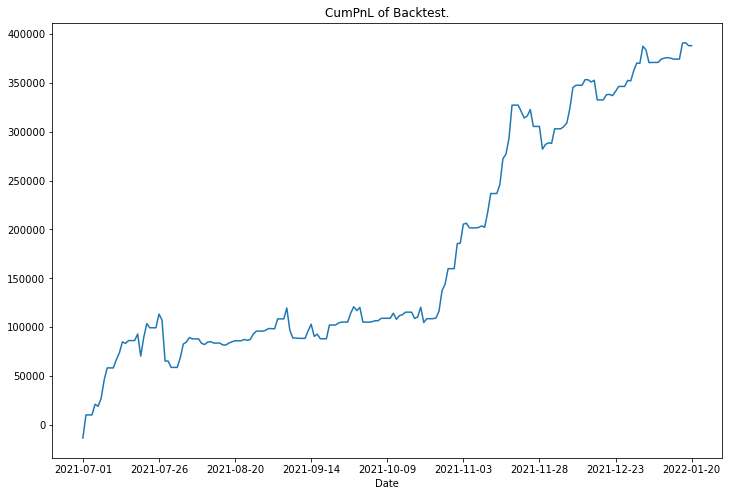

In [26]:
plot_df.CumPnL.plot(figsize=(12,8), title="CumPnL of Backtest.")

In [19]:
plot_df.CumPnL.iloc[-1]

228130